# Preprocessing fundamentals

Defining functions to get year on year price increases that will function as labels:

In [12]:
import pandas as pd
import numpy as np
import datetime as dt
import ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#First we need to drop symbols that are in the prices dataset which are not in the fundamentals dataset
def dropSymbolsNotInAnotherDataframe(firstDataFrame,secondDataFrame,firstDFColumnName,secondDFColumnName):
    #All unique symbols are stored in a list
    secondSymbols = secondDataFrame[secondDFColumnName].unique()
    firstSymbols = firstDataFrame[firstDFColumnName].unique()
    symbolsOnlyInFirst = [] 
    for symbol in firstSymbols:
        if symbol not in secondSymbols:
            symbolsOnlyInFirst.append(symbol)
    
    #Overwrites the dataframe each loop, dropping all entries of a specific symbol.
    for symbol in symbolsOnlyInFirst:
        firstDataFrame = firstDataFrame[firstDataFrame[firstDFColumnName] != symbol]
    
    return firstDataFrame
    
def yearOnYearChange(dataFrame,startDate,endDate): #Use a dataset with 'change' columns
    #All unique symbols are stored in a list.
    symbolList = dataFrame['symbol'].unique()
    dataFrame['date'] = pd.to_datetime(dataFrame['date']) #Converts 'str' to datetime
    #We are only interested in a specific year so entries outside that year are dropped.
    dataFrame = dataFrame[(dataFrame['date']>=startDate) & (dataFrame['date']<=endDate)]
    data = []
    #For each symbol: sum up the daily change % and append the symbol and the summed value to a list
    for symbol in symbolList:
        symbolDataFrame = dataFrame[dataFrame['symbol'] == symbol]
        changeValues = symbolDataFrame['change'].tolist()
        changeSum = sum(changeValues)
        data.append([str(startDate.year),symbol,changeSum])
    #Year on Year dataframe is created using the 'data' list, and sorted alphabetically.
    newDataFrame = pd.DataFrame(data, columns = ['year','symbol','change in 12 months'])
    newDataFrame = newDataFrame.sort_values('symbol')
    return newDataFrame



In [13]:
fundamentals = pd.read_csv("./fundamentals.csv", index_col=0)
pricesAll = pd.read_csv("preprocessing/pricesAll.csv")
pricesAll = dropSymbolsNotInAnotherDataframe(pricesAll,fundamentals,'symbol','Ticker Symbol')
yearOnYear11 = yearOnYearChange(pricesAll,pd.Timestamp(2011,1,1),pd.Timestamp(2011,12,31))
yearOnYear11.to_csv("preprocessing/YoY11.csv", index = False)
yearOnYear12 = yearOnYearChange(pricesAll,pd.Timestamp(2012,1,1),pd.Timestamp(2012,12,31))
yearOnYear12.to_csv("preprocessing/YoY12.csv", index = False)
yearOnYear13 = yearOnYearChange(pricesAll,pd.Timestamp(2013,1,1),pd.Timestamp(2013,12,31))
yearOnYear13.to_csv("preprocessing/YoY13.csv", index = False)
yearOnYear14 = yearOnYearChange(pricesAll,pd.Timestamp(2014,1,1),pd.Timestamp(2014,12,31))
yearOnYear14.to_csv("preprocessing/YoY14.csv", index = False)
yearOnYear15 = yearOnYearChange(pricesAll,pd.Timestamp(2015,1,1),pd.Timestamp(2015,12,31))
yearOnYear15.to_csv("preprocessing/YoY15.csv", index = False)
yearOnYear16 = yearOnYearChange(pricesAll,pd.Timestamp(2016,1,1),pd.Timestamp(2016,12,31))
yearOnYear16.to_csv("preprocessing/YoY16.csv", index = False)
allYearOnYears = yearOnYear11.append(yearOnYear12).append(yearOnYear13).append(yearOnYear14).append(yearOnYear15).append(yearOnYear16)
allYearOnYears.to_csv("preprocessing/YoYall.csv", index = False)

In [14]:
allYearOnYears.head(10)



,year,symbol,change in 12 months
0,2011,AAL,105.286623
1,2011,AAP,-17.256655
2,2011,AAPL,1.450223
3,2011,ABC,-9.437829
4,2011,ABT,-6.784372
5,2011,ADBE,-16.081756
6,2011,ADI,6.381454
7,2011,ADM,24.891664
8,2011,ADS,-23.139270
9,2011,ADSK,10.760581


In [15]:
print(allYearOnYears.shape)

(2502, 3)


## All years sorted by highest increase 2011 - 2016 

In [16]:
print(allYearOnYears.sort_values('change in 12 months', ascending = False)) #Sort from highest to lowest value.

     year symbol  change in 12 months
159  2011   FSLR           140.838292
45   2011    BAC           135.262041
0    2011    AAL           105.286623
346  2011   SWKS            90.085055
347  2015    SWN            81.540805
..    ...    ...                  ...
347  2016    SWN           -76.588644
271  2012   NFLX           -77.282476
288  2013    PBI           -77.303476
49   2013    BBY           -80.947308
282  2016    OKE           -95.267039

[2502 rows x 3 columns]


## Distrubtion of YoY for all companies each year

Mean of all Year on Year price changes is -9.748451575194077


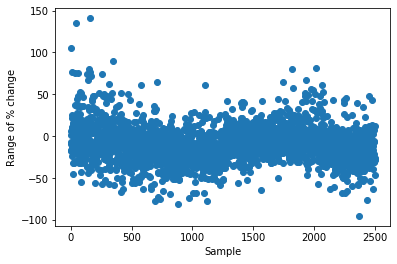

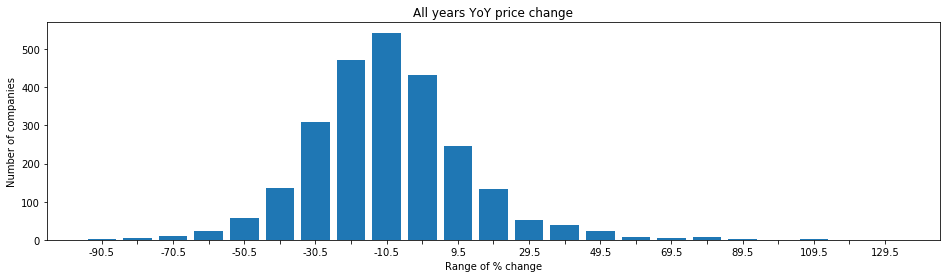

In [17]:

def plotYoYForAllSymbols(dataFrame, title, tick_step):
    #To plot the change in 12 months for all symbols, a range of values needs to be chosen
    #which will then show how many different symbols are within that particular range.
    allChanges = dataFrame['change in 12 months'].tolist()
    ranges = [] #Stores range labels.
    startingRange = np.min(allChanges) #Which value will the function begin sorting 'YoY' values from
    endingRange = np.max(allChanges) #The maximum value for which the function will sort 'YoY'
    rangeIncrease = 10 #This number will be the range of a single label.
    tempStartingRange = startingRange
    #The amount of total labels created is the sum of absolute starting and ending ranges
    #divided by range increase. DATA MAY BE LOST IF THE RESULT IS NOT A WHOLE NUMBER.
    for x in range(0,(int((abs(endingRange)+abs(startingRange))/rangeIncrease))):
        ranges.append([tempStartingRange,(tempStartingRange + rangeIncrease)])
        tempStartingRange += rangeIncrease
    
    changesInRange = {} #(As of Python 3.6 dictionaries remember the order of items inserted.)
    
    #For each range label and for each 'YoY' value, check if that specific value is within that range.
    #If it is, then the value will be assigned to the range label.
    #For example, if a range label is [20,30] then any values that are 20 or greater than 20 but less than 30
    #will be assigned to that range label.
    for valueRange in ranges:
        valuesInRange = []
        for value in allChanges:
            if (value>=valueRange[0]) & (value < valueRange[1]):
                valuesInRange.append(value)
        changesInRange[(valueRange[0] + valueRange[1])/2] = valuesInRange
    
    xPos = [i for i,_ in enumerate(ranges)]
    yValues = []
    
    for x in changesInRange:
        yValues.append(len(changesInRange[x]))
    xLabels = []
    for x in ranges:
        xLabels.append((np.round(x[0] + x[1]) / 2))
        
        
    plt.figure(figsize=(16,4)) #Change as appropriate to fit all x labels for a specific set of ranges.
    plt.bar(xPos,yValues, align = 'center')
    plt.xticks(xPos,xLabels)
    plt.ylabel("Number of companies")
    plt.xlabel("Range of % change")
    plt.title(title)

      ##Just show every fourth xTicker
    every_nth = tick_step
    ax = plt.gca() #get current axis
    for x, label in enumerate(ax.xaxis.get_ticklabels()):
        if x % every_nth != 0:
            label.set_visible(False)
    
    
    
    
plt.scatter(np.arange(0,len(allYearOnYears)),allYearOnYears.iloc[:]["change in 12 months"])
plt.ylabel("Range of % change")
plt.xlabel("Sample")
yoyMean = np.mean(allYearOnYears.iloc[:]["change in 12 months"].values)
print("Mean of all Year on Year price changes is {}".format(yoyMean))
plotYoYForAllSymbols(allYearOnYears, "All years YoY price change", 2)

***
## Feature extracting

In [18]:
fundamentals = pd.read_csv("./fundamentals.csv", index_col=0)
fundamentals.columns


Index(['Ticker Symbol', 'Period Ending', 'Accounts Payable',
       'Accounts Receivable', 'Add'l income/expense items', 'After Tax ROE',
       'Capital Expenditures', 'Capital Surplus', 'Cash Ratio',
       'Cash and Cash Equivalents', 'Changes in Inventories', 'Common Stocks',
       'Cost of Revenue', 'Current Ratio', 'Deferred Asset Charges',
       'Deferred Liability Charges', 'Depreciation',
       'Earnings Before Interest and Tax', 'Earnings Before Tax',
       'Effect of Exchange Rate',
       'Equity Earnings/Loss Unconsolidated Subsidiary', 'Fixed Assets',
       'Goodwill', 'Gross Margin', 'Gross Profit', 'Income Tax',
       'Intangible Assets', 'Interest Expense', 'Inventory', 'Investments',
       'Liabilities', 'Long-Term Debt', 'Long-Term Investments',
       'Minority Interest', 'Misc. Stocks', 'Net Borrowings', 'Net Cash Flow',
       'Net Cash Flow-Operating', 'Net Cash Flows-Financing',
       'Net Cash Flows-Investing', 'Net Income', 'Net Income Adjustments',
  

In [19]:
fundamentals = pd.read_csv("./fundamentals.csv", index_col=0)
fundamentals.columns
fundamentals.columns.shape


(78,)

In [20]:
fundamentals.head()

,Ticker Symbol,Period Ending,Accounts Payable,Accounts Receivable,Add'l income/expense items,After Tax ROE,Capital Expenditures,Capital Surplus,Cash Ratio,Cash and Cash Equivalents,...,Total Current Assets,Total Current Liabilities,Total Equity,Total Liabilities,Total Liabilities & Equity,Total Revenue,Treasury Stock,For Year,Earnings Per Share,Estimated Shares Outstanding
0,AAL,2012-12-31,3.068000e+09,-222000000.0,-1.961000e+09,23.0,-1.888000e+09,4.695000e+09,53.0,1.330000e+09,...,7.072000e+09,9.011000e+09,-7.987000e+09,2.489100e+10,1.690400e+10,2.485500e+10,-367000000.0,2012.0,-5.60,3.350000e+08
1,AAL,2013-12-31,4.975000e+09,-93000000.0,-2.723000e+09,67.0,-3.114000e+09,1.059200e+10,75.0,2.175000e+09,...,1.432300e+10,1.380600e+10,-2.731000e+09,4.500900e+10,4.227800e+10,2.674300e+10,0.0,2013.0,-11.25,1.630222e+08
2,AAL,2014-12-31,4.668000e+09,-160000000.0,-1.500000e+08,143.0,-5.311000e+09,1.513500e+10,60.0,1.768000e+09,...,1.175000e+10,1.340400e+10,2.021000e+09,4.120400e+10,4.322500e+10,4.265000e+10,0.0,2014.0,4.02,7.169154e+08
3,AAL,2015-12-31,5.102000e+09,352000000.0,-7.080000e+08,135.0,-6.151000e+09,1.159100e+10,51.0,1.085000e+09,...,9.985000e+09,1.360500e+10,5.635000e+09,4.278000e+10,4.841500e+10,4.099000e+10,0.0,2015.0,11.39,6.681299e+08
4,AAP,2012-12-29,2.409453e+09,-89482000.0,6.000000e+05,32.0,-2.711820e+08,5.202150e+08,23.0,5.981110e+08,...,3.184200e+09,2.559638e+09,1.210694e+09,3.403120e+09,4.613814e+09,6.205003e+09,-27095000.0,2012.0,5.29,7.328355e+07


***
## We are looking for a mix of valuation metrics and strength metrics

We are looking for a mix of valuation metrics and strength metrics as we suggest the potential price increase of a stock is based upon its value and financial strength.

## Valuation Metrics
    
    1.PE = price / eps
        1.1 price = (price beginning of year + price end of year) / 2
    2.PEG Ratio= PE / eps growth
        2.eps growth = (eps end of year / eps beginning of year) - 1 * 100
        
       


In [21]:
import math

def calculatePE(fundamentals,prices, startDate, endDate):
    #Data Frames are sorted by dates in ascending order to make it easy to get the earliest and the latest date.
    fundamentals = fundamentals.sort_values('Period Ending', ascending = True)
    prices = prices.sort_values('date', ascending = True)
    prices['date'] = pd.to_datetime(prices['date']) #Converts 'str' to datetime
    fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])
    #Dates that are not specified in the functions are not necessary, so they are dropped.
    fundamentals = fundamentals[(fundamentals['Period Ending']>=startDate) & (fundamentals['Period Ending']<=endDate)]
    prices = prices[(prices['date']>=startDate) & (prices['date']<=endDate)]
    symbolList = prices['symbol'].unique()
    
    pe = [] #Data for a new data frame
    #Note: some entries for symbols in fundamentals have a different end date than the entries for same symbols in prices.
    #In most cases, that difference is a few days. However, there are a few outliers in which the final dates for a
    #particular symbol is at least one month apart.
    for symbol in symbolList:
        try: #Some symbols don't have entires on certain years.
            fundamentalEntry = fundamentals[fundamentals['Ticker Symbol'] == symbol].tail(1) #End of year is 
            priceEntries = [prices[prices['symbol'] == symbol].head(1), prices[prices['symbol'] == symbol].tail(1)]#[Beginning of year,End of year]
            priceAverage = (priceEntries[0].iloc[0]['open'] + priceEntries[1].iloc[0]['open'])/2
            eps = fundamentalEntry.iloc[0]['Earnings Per Share']
            if math.isnan(eps) == False: #Some entries for EPS in fundamentals are null.
                calculation = priceAverage / eps
                pe.append([str(startDate.year),symbol,calculation])
        except IndexError:
            pass
        
    newDataFrame = pd.DataFrame(pe, columns = ['year','symbol','PE'])
    newDataFrame = newDataFrame.sort_values('symbol')
    return newDataFrame

def calculatePEGRatio(fundamentals,peDataFrame,startDate,endDate):
    #Data Frames are sorted by dates in ascending order to make it easy to get the earliest and the latest date.
    fundamentals = fundamentals.sort_values('Period Ending', ascending = True)
    fundamentals['Period Ending'] = pd.to_datetime(fundamentals['Period Ending'])
    #Many entries in fundamentals are only per year, so in that case the beginning of year would be 'target year - 1 year'
    fundamentals = fundamentals[(fundamentals['Period Ending']>=(startDate - pd.DateOffset(years=1))) & (fundamentals['Period Ending']<=endDate)]
    peDataFrame['year'] = pd.to_datetime(peDataFrame['year']) 
    peDataFrame = peDataFrame[(peDataFrame['year']>=startDate) & (peDataFrame['year']<=endDate)]
    symbolList = peDataFrame['symbol'].unique()
    
    pegRatio = [] #Data for a new data frame
    for symbol in symbolList:
        try: #Some symbols don't have entries on certain years.
            fundamentalEntries = [fundamentals[fundamentals['Ticker Symbol'] == symbol].head(1),fundamentals[fundamentals['Ticker Symbol'] == symbol].tail(1)]
            peEntry = peDataFrame[peDataFrame['symbol'] == symbol]
            beginningOfYearEPS = fundamentalEntries[0].iloc[0]['Earnings Per Share']
            endOfYearEPS = fundamentalEntries[1].iloc[0]['Earnings Per Share']
            #Any symbol with null entries for EPS are discarded:
            if (math.isnan(beginningOfYearEPS) == False) & (math.isnan(endOfYearEPS) == False):
                epsGrowth = ((endOfYearEPS / beginningOfYearEPS) - 1 ) * 100
                if epsGrowth != 0: #Check for rare cases where growth is 0 so we don't divide when that happens.
                    pe = peEntry.iloc[0]['PE']
                    ratio = pe/epsGrowth
                    pegRatio.append([str(startDate.year),symbol,pe,ratio])
                
        except IndexError:
            pass
    
    newDataFrame = pd.DataFrame(pegRatio, columns = ['year','symbol','PE','PEG'])
    newDataFrame = newDataFrame.sort_values('symbol')
    return newDataFrame

##Calculate PE-value for each company for each year
peYear12 = calculatePE(fundamentals,pricesAll, pd.Timestamp(2012,1,1),pd.Timestamp(2012,12,31))
peYear13 = calculatePE(fundamentals,pricesAll, pd.Timestamp(2013,1,1),pd.Timestamp(2013,12,31))
pegYear13 = calculatePEGRatio(fundamentals,peYear13, pd.Timestamp(2013,1,1),pd.Timestamp(2013,12,31))
peYear14 = calculatePE(fundamentals,pricesAll, pd.Timestamp(2014,1,1),pd.Timestamp(2014,12,31))
pegYear14 = calculatePEGRatio(fundamentals,peYear14, pd.Timestamp(2014,1,1),pd.Timestamp(2014,12,31))
peYear15 = calculatePE(fundamentals,pricesAll, pd.Timestamp(2015,1,1),pd.Timestamp(2015,12,31))
pegYear15 = calculatePEGRatio(fundamentals,peYear15, pd.Timestamp(2015,1,1),pd.Timestamp(2015,12,31))
peYear16 = calculatePE(fundamentals,pricesAll, pd.Timestamp(2016,1,1),pd.Timestamp(2016,12,31))
pegYear16 = calculatePEGRatio(fundamentals,peYear16, pd.Timestamp(2016,1,1),pd.Timestamp(2016,12,31))

##Saving pe-Dataframe to csv
peYear12.to_csv("preprocessing/peYear12.csv", index = False)
peYear13.to_csv("preprocessing/peYear13.csv", index = False)
peYear14.to_csv("preprocessing/peYear14.csv", index = False)
peYear15.to_csv("preprocessing/peYear15.csv", index = False)
peYear16.to_csv("preprocessing/peYear16.csv", index = False)

##Saving all years
peAllYears = peYear12.append(peYear13).append(peYear14).append(peYear15).append(peYear16)
peAllYears.to_csv("preprocessing/peAllYears.csv", index = False)


#save peg
pegYear13.to_csv("preprocessing/pegYear13.csv", index = False)
pegYear14.to_csv("preprocessing/pegYear14.csv", index = False)
pegYear15.to_csv("preprocessing/pegYear15.csv", index = False)
pegYear16.to_csv("preprocessing/pegYear16.csv", index = False)
pegAllYears = pegYear13.append(pegYear14).append(pegYear15).append(pegYear16)
pegAllYears.to_csv("preprocessing/pegAllYears.csv", index = False)

In [22]:
print(pegAllYears.shape)
pegAllYears.head(10)

(1051, 4)


,year,symbol,PE,PEG
0,2013,AAL,-1.709333,-0.016942
1,2013,AAP,17.097948,12.921163
2,2013,ABT,21.548780,-0.382186
3,2013,ADS,20.211099,1.033828
4,2013,AEE,28.315126,-0.218353
5,2013,AEP,14.792763,0.874118
6,2013,AFL,8.916177,0.829475
7,2013,AIV,19.132143,0.147729
8,2013,AKAM,26.921212,0.619188
9,2013,ALB,12.867140,0.311849


In [23]:
print(peAllYears.shape)
peAllYears.head(-10)

(1478, 3)


,year,symbol,PE
147,2012,AAL,-1.611607
146,2012,AAP,13.471644
145,2012,ABT,7.701676
144,2012,ADS,14.604857
148,2012,AEE,-7.975062
...,...,...,...
47,2016-01-01 00:00:00,SYMC,6.035040
46,2016-01-01 00:00:00,SYY,29.051204
45,2016-01-01 00:00:00,TEL,12.180328
44,2016-01-01 00:00:00,TGT,13.509345


## Join the PE and PEG with the YoY-labels

In [24]:

print(len(pegAllYears['symbol'].unique())) 
      
print(len(allYearOnYears['symbol'].unique()))
    

#Make sure both datasets have the same amount of unique symbols.
allYearOnYears = dropSymbolsNotInAnotherDataframe(allYearOnYears, pegAllYears, 'symbol','symbol')
print(len(pegAllYears['symbol'].unique()))       
print(len(allYearOnYears['symbol'].unique()))
    

symbolList = allYearOnYears['symbol'].unique()
indexListToDrop = []


allYearOnYears = allYearOnYears.reset_index(drop=True)
pegAllYears = pegAllYears.reset_index(drop=True)

for symbol in symbolList:
    #Get a subset of all entries of a particular symbol.
    symbolSubSetYoY =  allYearOnYears[allYearOnYears['symbol'] == symbol]
    for index, row in symbolSubSetYoY.iterrows():
        #Check whether pegAllYears has the same combination of 'year' and 'symbol' as the one in the current row.
        yearSubset = pegAllYears[(pegAllYears['symbol']==symbol) & (pegAllYears['year'] == row['year'])]
        if yearSubset.empty == True:
            indexListToDrop.append(index)
    
    

newFrame = allYearOnYears.drop(indexListToDrop, inplace=False) 


#Both datasets should have the same amount of rows.
print(newFrame.shape)
print(pegAllYears.shape)
newFrame.head()
#Sort dataframes so that columns are appended to the appropriate index.
pegAllYears = pegAllYears.sort_values(['symbol', 'year'], ascending=[True, True])
newFrame = newFrame.sort_values(['symbol', 'year'], ascending=[True,True])


newFrame = newFrame.reset_index(drop=True)

pegAllYears = pegAllYears.reset_index(drop=True)

#Append PE and PEG columns
newFrame['PE'] = pegAllYears['PE']
newFrame['PEG'] = pegAllYears['PEG']

newFrame.head()


394
417
394
394
(1051, 3)
(1051, 4)


,year,symbol,change in 12 months,PE,PEG
0,2013,AAL,7.170114,-1.709333,-0.016942
1,2014,AAL,-51.006113,9.822140,-0.072364
2,2015,AAL,28.144811,4.250219,0.023183
3,2013,AAP,-1.966070,17.097948,12.921163
4,2016,AAP,-21.102306,24.850388,-5.591337


As two consecutive years are needed to calculate PEG ratio we only get 1051 entries. However, we will save this and try to train the machine learning algorithms with it.

***

## Visualize PE and PEG to detect outliers.

Mean of PE is 22.827520376461877
Standard deviation for PE is 66.54566660092297
Mean of PEG is 0.6793510044268223


NameError: name 'pegStd' is not defined

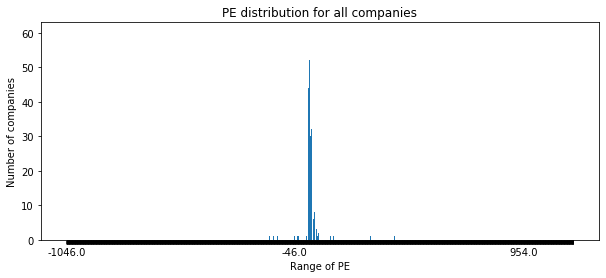

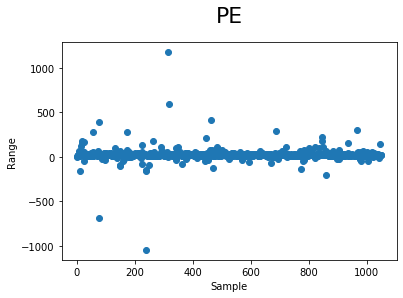

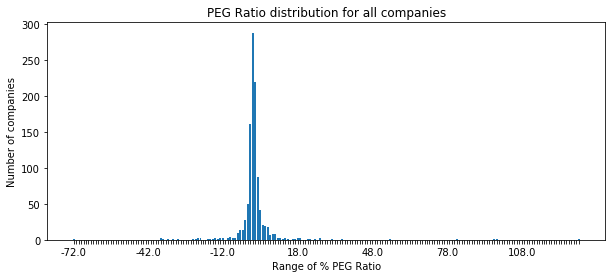

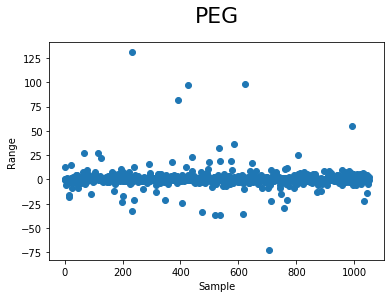

In [25]:
#Generalized function of plotYoYForAllSymbols:
def plotTargetValuesForAllSymbols(dataFrame,rangeValues,targetColumn,xLabel,title, tick_step):
    #To plot the values of target column for all symbols, a range of values needs to be chosen
    #which will then show how many different symbols are within that particular range.
    allValues = dataFrame[targetColumn].tolist()
    ranges = [] #Stores range labels.
    startingRange = np.min(allValues) #Which value will the function begin sorting from
    if startingRange>0: #Prevents the 'for' loop directly below from working incorrectly.
        startingRange = 0
    endingRange = np.max(allValues) #The maximum value for which the function will sort target column values.
    rangeIncrease = rangeValues[2] #This number will be the range of a single label.
    tempStartingRange = startingRange
    #The amount of total labels created is the sum of absolute starting and ending ranges
    #divided by range increase. DATA MAY BE LOST IF THE RESULT IS NOT A WHOLE NUMBER.
    #This function also assumes the starting range is a negative number or 0.
    for x in range(0,(int((abs(endingRange+rangeIncrease)+abs(startingRange))/rangeIncrease))):
        ranges.append([tempStartingRange,(tempStartingRange + rangeIncrease)])
        tempStartingRange += rangeIncrease
    
    dataInRange = {} #(As of Python 3.6 dictionaries remember the order of items inserted, which allows them to be accurately used for plotting a graph.)
    
    #For each range label and for each target column value, check if that specific value is within that range.
    #If it is, then the value will be assigned to the range label.
    #For example, if a range label is [20,30] then any values that are 20 or greater than 20 but less than 30
    #will be assigned to that range label.
    for valueRange in ranges:
        valuesInRange = []
        for value in allValues:
            if (value>=valueRange[0]) & (value < valueRange[1]):
                valuesInRange.append(value)
        dataInRange[valueRange[0]] = valuesInRange

    xPos = [i for i,_ in enumerate(ranges)] #We get a list of all range label indices.
    yValues = []
    
    for x in dataInRange:
        yValues.append(len(dataInRange[x])) #We get the amount of companies that are in each range label.
        
    xTickLabels = []
    for x in ranges:
        xTickLabels.append(np.round(x[0])) #Rounds the value to be used as a label to make sure it fits properly on the graph.

    plt.figure(figsize=(10,4)) #Change as appropriate to fit all x labels for a specific set of ranges.
    plt.bar(xPos,yValues, align = 'center')
    plt.xticks(xPos,xTickLabels)
    
    ##Just show every nth xTicker
    every_nth = tick_step
    ax = plt.gca() #get current axis
    for x, label in enumerate(ax.xaxis.get_ticklabels()):
        if x % every_nth != 0:
            label.set_visible(False)
  
    
    plt.ylabel("Number of companies")
    plt.xlabel(xLabel)
    plt.title(title)

#Parameters: Dataframe, Ranges of x values (starting range, ending range, step), target column, x axis label, graph title 
plotTargetValuesForAllSymbols(newFrame,[-66,72,1],'PE','Range of PE', "PE distribution for all companies",1000)


plt.figure()

plt.title("PE", fontsize=22, pad=20)
plt.xlabel("Sample")
plt.ylabel("Range")
plt.scatter(np.arange(0,len(newFrame.PE)),newFrame.PE)
peMean = np.mean(newFrame.PE.values)
peStd = np.std(newFrame.PE.values)
print("Mean of PE is {}".format(peMean))
print("Standard deviation for PE is {}".format(peStd))



plotTargetValuesForAllSymbols(newFrame, [-9,9,1],'PEG', 'Range of % PEG Ratio', "PEG Ratio distribution for all companies",30)




plt.figure()

plt.scatter(np.arange(0,len(newFrame.PEG)),pegAllYears.PEG)
plt.title("PEG", fontsize=22, pad=20)
plt.xlabel("Sample")
plt.ylabel("Range")
pegMean = np.mean(newFrame.PEG.values)
pegAverage = np.average(newFrame.PEG.values)
print("Mean of PEG is {}".format(pegMean))
print("Standard deviation for PEG is {}".format(pegStd))





EPS is also subject to different interpretation of the outliers. It is subject to an even larger complexity as it also inherits all the complexity of the PE value during the calculation. A negative value can either be explained by a negative PE value or a negative growth. Both a negative growth and a negative PE value would result in a positive value. We will also squash the distubtuion down to one standard deviation.

There are some very large prices and that is beacuse the EPS has to be between 0 and 1. But we do not want to erase these beacuse it says that the earnings are very small. So the decision surface will be non linear because a PE value of 1 and 3000 are more similiar than for a company with 20 and 200. However we squash these into values of -50 and 50.
 
Also a negative value is incling that the earnings are negative which also say something about the stock. For example. some companies (e.g. Tech Companies} do have negative earnings. It does not mean that those companies' stocks will not have a large increase of its stock price. Therefore, the decsion boundaries will be even more complex but there are algorithms, such as Neural Networks, that can find functions in very high dimensions. 
***

## Converting

     year symbol  change in 12 months    PE        PEG
226  2015    COG             3.200208 -50.0   0.392183
979  2015   VRTX            -5.585274 -50.0   2.010465
772  2015    PNR             7.101422 -50.0   1.011098
471  2016     HP           -45.818691 -50.0   1.069670
238  2015    CRM           -13.635103 -50.0 -20.000000
..    ...    ...                  ...   ...        ...
132  2015    BCR           -14.502627  50.0  -1.871396
987  2016    WDC             4.782087  50.0  -0.753652
148  2015    BMY             2.193668  50.0  -3.064332
74   2015    AMT             2.568313  50.0  -2.336751
707  2016   NVDA           -58.466899  50.0 -20.000000

[1051 rows x 5 columns]
Mean of PE is 19.742210324103002
Standard deviation for PE is 16.333161700622885
Mean of PEG is 0.4291007119774425
Standard deviation for PEG is 4.531494891120901


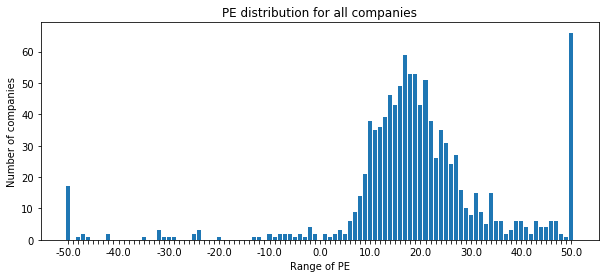

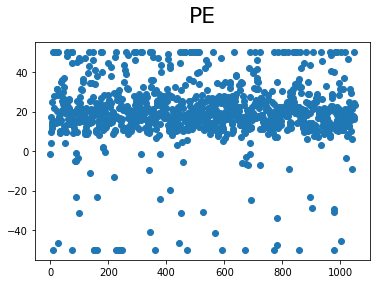

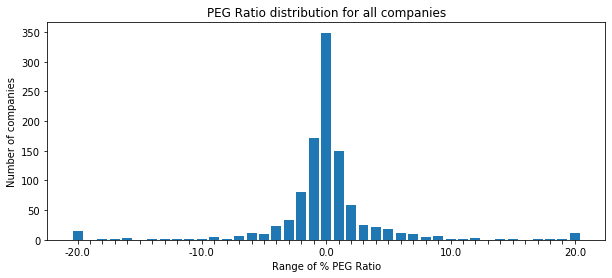

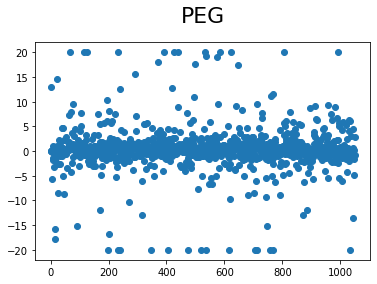

In [51]:
def convertColumnValueByRange(dataFrame,targetColumn,upperRange,lowerRange,newValue):
    tempDataFrame = dataFrame.copy()
    tempDataFrame = tempDataFrame.reset_index(drop=True)
    #If a value in column is greater than upper range, it is overwritten by newValue
    tempDataFrame.loc[tempDataFrame[targetColumn]>upperRange,targetColumn] = newValue
    #If a value in column is less than lower range, it is overwritten by negative newValue
    tempDataFrame.loc[tempDataFrame[targetColumn]<lowerRange,targetColumn] = -newValue
    return tempDataFrame


dr = convertColumnValueByRange(newFrame, "PE", 50, -50, 50)

dr = convertColumnValueByRange(dr, "PEG", 20, -20, 20)



print(dr.sort_values("PE"))

#Parameters: Dataframe, Ranges of x values (starting range, ending range, step), target column, x axis label, graph title, show nth tick label 
plotTargetValuesForAllSymbols(dr,[-66,72,1],'PE','Range of PE', "PE distribution for all companies",10)
plt.figure()
plt.title("PE", fontsize=22, pad=20)
plt.scatter(np.arange(0,len(dr)),dr.PE)
peMean = np.mean(dr.PE.values)
peStd = np.std(dr.PE.values)
print("Mean of PE is {}".format(peMean))
print("Standard deviation for PE is {}".format(peStd))






plotTargetValuesForAllSymbols(dr, [-9,9,1],'PEG', 'Range of % PEG Ratio', "PEG Ratio distribution for all companies",10)
plt.figure()
plt.scatter(np.arange(0,len(dr)),dr.PEG)
plt.title("PEG", fontsize=22, pad=20)
pegMean = np.mean(dr.PEG.values)
pegAverage = np.average(dr.PEG.values)
pegStd = np.std(dr.PEG.values)
print("Mean of PEG is {}".format(pegMean))
print("Standard deviation for PEG is {}".format(pegStd))




# Financial Metrics
We need to have general financial metrics as the dataset includes companies from a wide variety of branches and industry with different financial models. For example, revenue as a feature would not generalize well as some companies have very large revenues but small margins. Even though some of the metrics are industry dependent, they should be seperable in a sufficiently high dimension. 


## Profitability

    1.ROE is a measure of how well a company uses investments to generate earnings growth.
        Return on equity.
        
    2. Gross Margin
        Revenu - Cost of goods sold
        
    3. Operating margin
        Margin after operative expenses.
    
    4. Profit margin
        Margin after tax.
        

## Solvency
    Cash ratio = How financially stable the company is in short term.


In [52]:
roeAndCashRatio = fundamentals[['Period Ending','Ticker Symbol','After Tax ROE','Gross Margin','Operating Margin','Profit Margin','Cash Ratio']]
roeAndCashRatio.head(10)
print("Are there any null values?")
roeAndCashRatio.isna().any()

Are there any null values?


Period Ending       False
Ticker Symbol       False
After Tax ROE       False
Gross Margin        False
Operating Margin    False
Profit Margin       False
Cash Ratio           True
dtype: bool

***

# Visualize and analyze Financial Metrics

We have learnt from the price-change predictions that it is important for the features to have some meaning in it. Therefore, we will analyse the distributions of the financial metrics to make a decision to keep them, alter them or drop them.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
fundamentals = pd.read_csv("./fundamentals.csv", index_col=0)


def plotScatterGraph(dataFrame,targetColumn,yLabel,xLabel,title):
    plt.figure(figsize=(10,4))
    plt.scatter(np.arange(len(dataFrame[targetColumn])), dataFrame[targetColumn])
    plt.xlabel(xLabel)
    plt.ylabel(yLabel)
    plt.title(title)

fundamentalsSubset = fundamentals[['Period Ending','Ticker Symbol','After Tax ROE','Gross Margin', 'Operating Margin','Profit Margin','Cash Ratio']]

print(fundamentalsSubset.shape)
##Filling all the empty records with the mean of that column
fundamentalsSubset = fundamentalsSubset.fillna(np.mean(fundamentalsSubset))

def printMeanAndSTD(dataFrame,targetColumn):
    print("Mean: ", np.mean(dataFrame[targetColumn]))
    print("Standard deviation: ", np.std(dataFrame[targetColumn]))


    



(1781, 7)


## ROE

Mean:  43.60134755755194
Standard deviation:  233.85834715450756


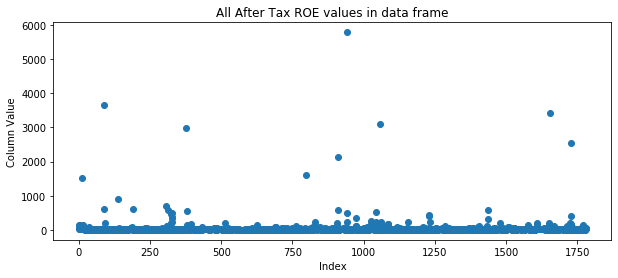

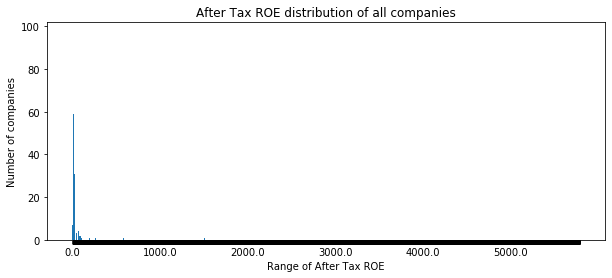

In [27]:
printMeanAndSTD(fundamentalsSubset,'After Tax ROE')
plotScatterGraph(fundamentalsSubset, 'After Tax ROE', 'Column Value', 'Index', 'All After Tax ROE values in data frame')
plotTargetValuesForAllSymbols(fundamentalsSubset,[0,143,1],'After Tax ROE', 'Range of After Tax ROE', 'After Tax ROE distribution of all companies', 1000)

## Gross Margin

Mean:  46.76305446378439
Standard deviation:  25.431724375419538


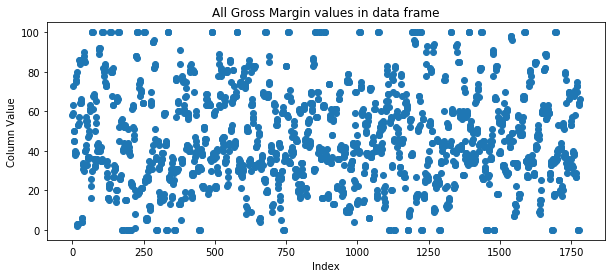

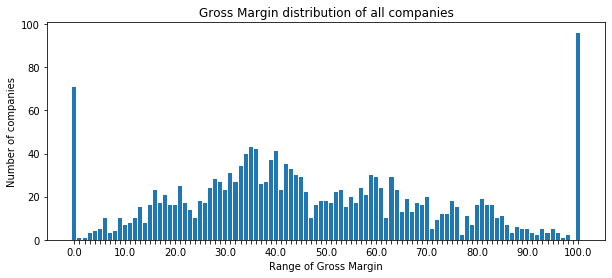

In [94]:
printMeanAndSTD(fundamentalsSubset,'Gross Margin')
plotScatterGraph(fundamentalsSubset, 'Gross Margin', 'Column Value', 'Index', 'All Gross Margin values in data frame')
plotTargetValuesForAllSymbols(fundamentalsSubset,[0,101,1],'Gross Margin','Range of Gross Margin', 'Gross Margin distribution of all companies', 10)

       
## Operating Margin
    

Mean:  18.17798989331836
Standard deviation:  20.498402139886426


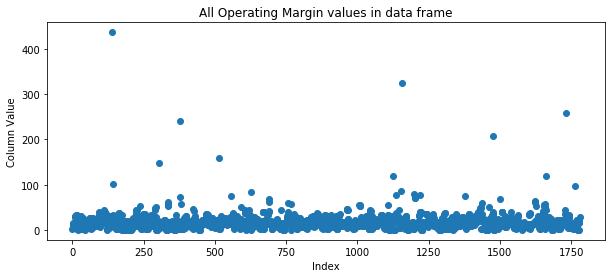

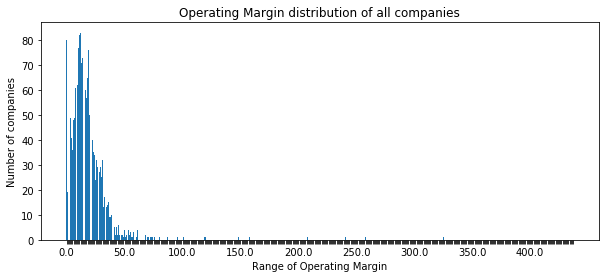

In [95]:
printMeanAndSTD(fundamentalsSubset,'Operating Margin')
plotScatterGraph(fundamentalsSubset, 'Operating Margin', 'Column Value', 'Index', 'All Operating Margin values in data frame')
plotTargetValuesForAllSymbols(fundamentalsSubset,[0,159,1], 'Operating Margin','Range of Operating Margin','Operating Margin distribution of all companies', 50)

## Profit Margin

Mean:  13.957888826501966
Standard deviation:  17.5547246002322


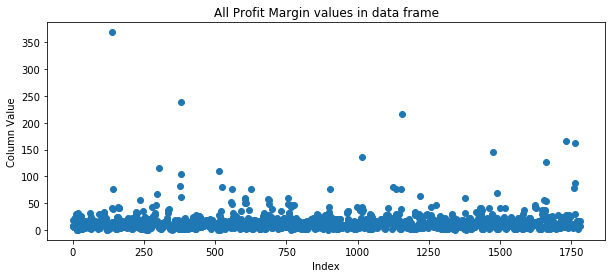

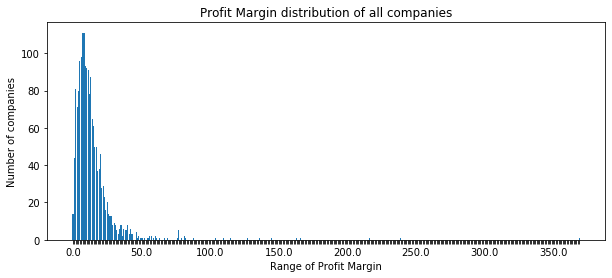

In [96]:
printMeanAndSTD(fundamentalsSubset,'Profit Margin')
plotScatterGraph(fundamentalsSubset, 'Profit Margin', 'Column Value', 'Index', 'All Profit Margin values in data frame')
plotTargetValuesForAllSymbols(fundamentalsSubset,[0,100,1], 'Profit Margin','Range of Profit Margin','Profit Margin distribution of all companies', 50)

## Cash Ratio

Mean:  74.45748987854209
Standard deviation:  93.28553373361468


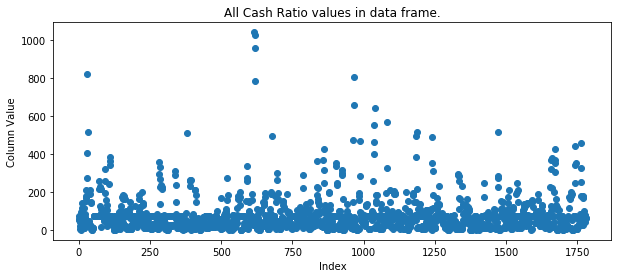

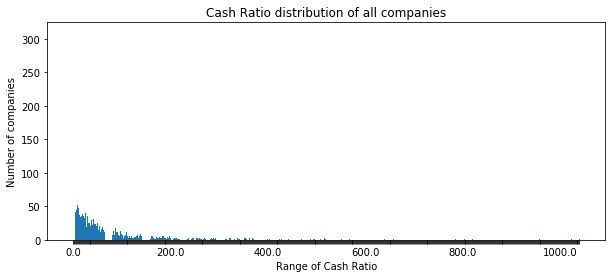

In [97]:
printMeanAndSTD(fundamentalsSubset,'Cash Ratio')
plotScatterGraph(fundamentalsSubset, 'Cash Ratio', 'Column Value', 'Index', 'All Cash Ratio values in data frame.')
plotTargetValuesForAllSymbols(fundamentalsSubset,[0,252,2], 'Cash Ratio', 'Range of Cash Ratio','Cash Ratio distribution of all companies', 100)

***
# Detect and Remove outliers

We will detect each column's outliers by a **Z-score** and a threshold of **2.5**.



In [30]:
from scipy import stats
import numpy as np 

features = fundamentalsSubset.iloc[:, 2:]

z = np.abs(stats.zscore(features))

outliers = np.where(z > 2.5)


print(outliers)


(array([  12,   28,   29,   31,   89,   93,  109,  110,  111,  139,  139,
        139,  142,  142,  283,  284,  295,  305,  305,  305,  339,  378,
        378,  378,  379,  379,  379,  380,  381,  514,  514,  523,  555,
        561,  590,  605,  616,  617,  618,  619,  627,  627,  679,  757,
        798,  835,  859,  861,  862,  902,  903,  904,  910,  924,  941,
        964,  965,  966,  987, 1017, 1035, 1036, 1037, 1038, 1059, 1081,
       1082, 1126, 1126, 1134, 1134, 1152, 1152, 1155, 1155, 1184, 1185,
       1186, 1200, 1201, 1202, 1203, 1219, 1219, 1240, 1241, 1242, 1377,
       1377, 1473, 1477, 1477, 1489, 1654, 1658, 1659, 1660, 1660, 1660,
       1671, 1672, 1673, 1727, 1732, 1732, 1741, 1743, 1744, 1761, 1761,
       1763, 1764, 1764, 1764]), array([0, 4, 4, 4, 0, 4, 4, 4, 4, 0, 2, 3, 2, 3, 4, 4, 3, 0, 2, 3, 4, 0,
       2, 3, 2, 3, 4, 3, 3, 2, 3, 3, 2, 3, 4, 3, 4, 4, 4, 4, 2, 3, 4, 3,
       0, 4, 4, 4, 4, 3, 4, 4, 0, 4, 0, 4, 4, 4, 4, 3, 4, 4, 4, 4, 0, 4,
       4, 2, 3, 2

In [31]:
print(np.unique(outliers[1], return_counts=True))
print(features.columns)

(array([0, 2, 3, 4]), array([11, 22, 29, 52]))
Index(['After Tax ROE', 'Gross Margin', 'Operating Margin', 'Profit Margin',
       'Cash Ratio'],
      dtype='object')


## Analysis

The first array shows the column number, and the second shows the amount of outliers.
As seen in the plots.


### Drop

In [33]:
no_outliers = fundamentalsSubset[(z < 2.5).all(axis=1)]
##peg and pe we 
print(no_outliers.shape)
no_outliers.head(5)



(1691, 7)


,Period Ending,Ticker Symbol,After Tax ROE,Gross Margin,Operating Margin,Profit Margin,Cash Ratio
0,2012-12-31,AAL,23.0,58.0,1.0,8.0,53.0
1,2013-12-31,AAL,67.0,59.0,5.0,7.0,75.0
2,2014-12-31,AAL,143.0,63.0,10.0,7.0,60.0
3,2015-12-31,AAL,135.0,73.0,15.0,19.0,51.0
4,2012-12-29,AAP,32.0,50.0,11.0,6.0,23.0


## Visualize without outliers
## ROE

Mean:  27.224127735068006
Standard deviation:  52.69180027701764


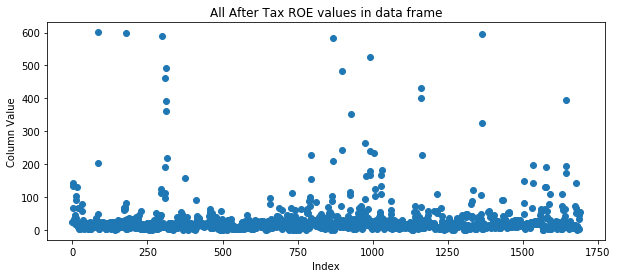

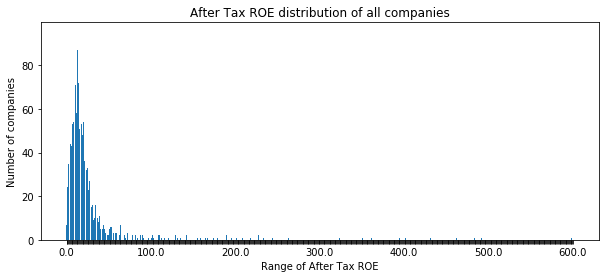

In [101]:
printMeanAndSTD(no_outliers,'After Tax ROE')
plotScatterGraph(no_outliers, 'After Tax ROE', 'Column Value', 'Index', 'All After Tax ROE values in data frame')
plotTargetValuesForAllSymbols(no_outliers,[0,143,1],'After Tax ROE', 'Range of After Tax ROE', 'After Tax ROE distribution of all companies', 100)

## Gross margin


Mean:  45.69485511531638
Standard deviation:  25.214919424510715


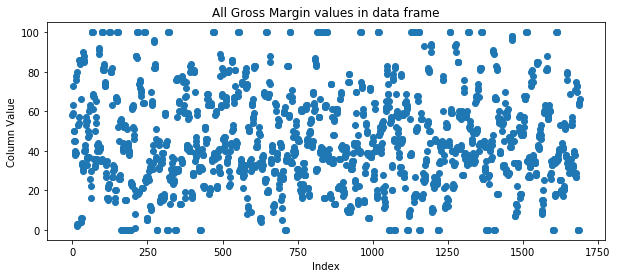

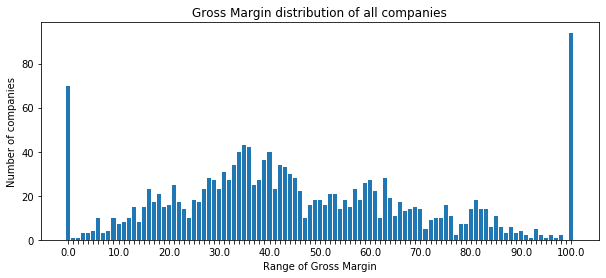

In [44]:
printMeanAndSTD(no_outliers,'Gross Margin')
plotScatterGraph(no_outliers, 'Gross Margin', 'Column Value', 'Index', 'All Gross Margin values in data frame')
plotTargetValuesForAllSymbols(no_outliers,[0,101,1],'Gross Margin','Range of Gross Margin', 'Gross Margin distribution of all companies', 10)

## Operating margin

Mean:  16.22767593140154
Standard deviation:  10.990919986805629


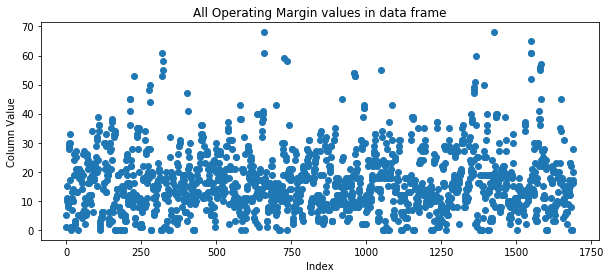

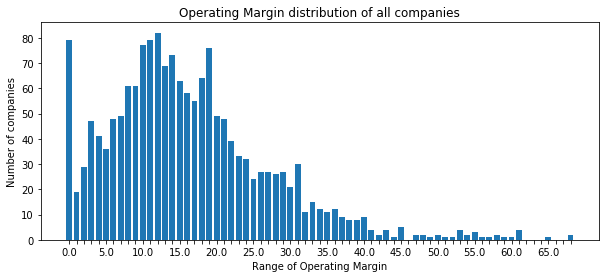

In [45]:
printMeanAndSTD(no_outliers,'Operating Margin')
plotScatterGraph(no_outliers, 'Operating Margin', 'Column Value', 'Index', 'All Operating Margin values in data frame')
plotTargetValuesForAllSymbols(no_outliers,[0,159,1], 'Operating Margin','Range of Operating Margin','Operating Margin distribution of all companies', 5)

## Profit margin

Mean:  11.982259018332348
Standard deviation:  8.866560138379018


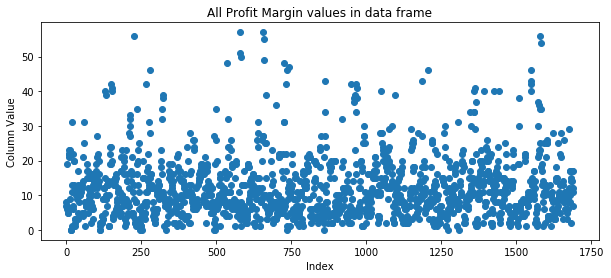

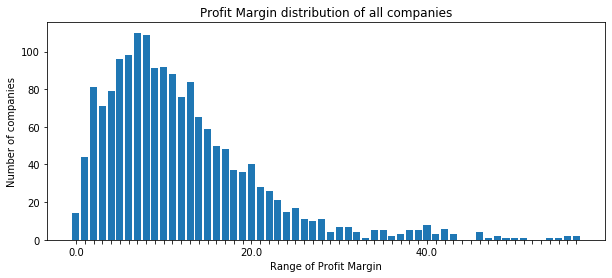

In [46]:
printMeanAndSTD( no_outliers,'Profit Margin')
plotScatterGraph(no_outliers, 'Profit Margin', 'Column Value', 'Index', 'All Profit Margin values in data frame')
plotTargetValuesForAllSymbols(no_outliers,[0,100,1], 'Profit Margin','Range of Profit Margin','Profit Margin distribution of all companies', 20)


## Cash ratio

Mean:  62.35376379355303
Standard deviation:  56.22660501711301


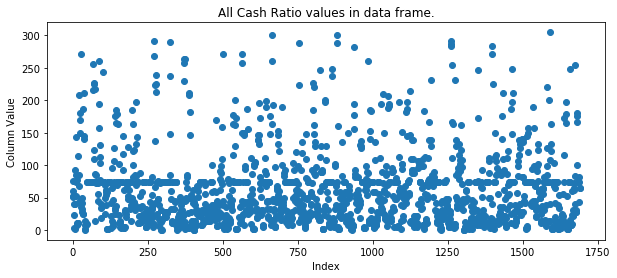

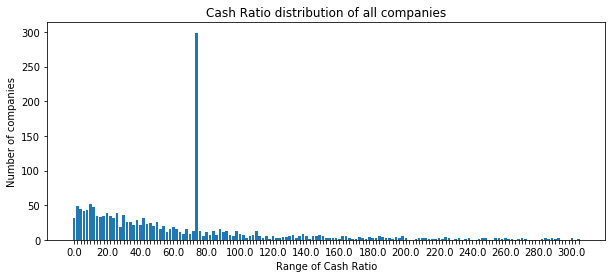

In [47]:
printMeanAndSTD(no_outliers,'Cash Ratio')
plotScatterGraph(no_outliers, 'Cash Ratio', 'Column Value', 'Index', 'All Cash Ratio values in data frame.')
plotTargetValuesForAllSymbols(no_outliers,[0,252,2], 'Cash Ratio', 'Range of Cash Ratio','Cash Ratio distribution of all companies', 10)

## Save the financial metrics

In [48]:
no_outliers.to_csv("./preprocessing/no_outliers.csv", index=False)

***

# Data cleaning

### Removal of unwanted observations
     We have identified unwanted observations of PEG and PE when the earning are between -1, 0, and 1, Therefore we scaled those down to -50 and 50.
    
### Fixing structural errors
    We have had to address this problem by combining two data sources, 'prices-split-adjusted' and 'fundamentals'. In the section before this we had to identify inner join between the year and symbols. We also had to convert the year type in order to compare the dates between them.
    
### Managing unwanted outliers
    Many suggest to be careful when removing outliers. However, we have some large outliers that do not represent the underlying data. We have therefore removed those by using Z-score and threshold.
        
 ### Handling missing data
    We have handled missing data by adding the column's mean to the empty records.
 
 
 
 ***


***
## Join Financial Metrics with YoY and Valuation dataframe.
We convert the year format in financial metrics to match the other dataframes.

In [49]:
#Intended to be used as a converter function:
def yearOnly(periodEndingEntry):
    return periodEndingEntry[:4]


financialMetric = pd.read_csv("./preprocessing/no_outliers.csv", converters={"Period Ending": yearOnly})

#Rename columns so they have the same name as the other data frames.
financialMetric = financialMetric.rename(columns={'Ticker Symbol': 'symbol', 'Period Ending': 'year'})

print(financialMetric.shape)
financialMetric.head()


(1691, 7)


,year,symbol,After Tax ROE,Gross Margin,Operating Margin,Profit Margin,Cash Ratio
0,2012,AAL,23.0,58.0,1.0,8.0,53.0
1,2013,AAL,67.0,59.0,5.0,7.0,75.0
2,2014,AAL,143.0,63.0,10.0,7.0,60.0
3,2015,AAL,135.0,73.0,15.0,19.0,51.0
4,2012,AAP,32.0,50.0,11.0,6.0,23.0


In [54]:


#Make sure both datasets have the same unique symbols
financialMetric = dropSymbolsNotInAnotherDataframe(financialMetric, dr, 'symbol', 'symbol')
dr = dropSymbolsNotInAnotherDataframe(dr, financialMetric, 'symbol', 'symbol')

print(len(financialMetric['symbol'].unique()))   
print(len(dr['symbol'].unique()))





symbolList = dr['symbol'].unique()
indexListToDrop = []


dr = dr.reset_index(drop=True)
financialMetric = financialMetric.reset_index(drop=True)

for symbol in symbolList:
    #Get a subset of all entries of a particular symbol
    financialMetricSubset =  financialMetric[financialMetric['symbol'] == symbol]
    for index, row in financialMetricSubset.iterrows():
        #Check whether 'dr' has the same entry combination of 'year' and 'symbol' as the one in the current row.
        yearSubset = dr[(dr['symbol']==symbol) & (dr['year'] == row['year'])]
        if yearSubset.empty == True:
            indexListToDrop.append(index)
    
    

newFinancialMetric = financialMetric.drop(indexListToDrop, inplace=False) 

indexListToDrop = [] #New index list to be used for 'dr'


dr = dr.reset_index(drop=True)
financialMetric = financialMetric.reset_index(drop=True)

for symbol in symbolList:
    #Get a subset of all entries for a particular symbol
    drSubset =  dr[dr['symbol'] == symbol]
    for index, row in drSubset.iterrows():
        #Check whether 'financialMetric' has the same entry combination of 'year' and 'symbol' as the one in the current row.        
        yearSubset = financialMetric[(financialMetric['symbol']==symbol) & (financialMetric['year'] == row['year'])]
        if yearSubset.empty == True:
            indexListToDrop.append(index)
            
newDR =  dr.drop(indexListToDrop, inplace = False)

#Both modified dataframes should have the same amount of rows.
print(newFinancialMetric.shape)
print(newDR.shape)

newFinancialMetric = newFinancialMetric.reset_index(drop = True)
newDR = newDR.reset_index(drop = True)
#Sort dataframes so that columns can be joined to their appropriate index.
newFinancialMetric.sort_values(['symbol', 'year'], ascending=[True, True] )
newDR.sort_values(['symbol', 'year'], ascending=[True, True] )
print(newFinancialMetric.head())
newDR.head()



columnsToBeAdded = newFinancialMetric.columns[2:]

##Add financial metrics to end of dataframe
for x in columnsToBeAdded:
    newDR[x] = newFinancialMetric[x]

    
print(newDR.shape)
newDR.head()

newDR.to_csv('./preprocessing/newDR.csv')

392
392
(999, 7)
(999, 5)
   year symbol  After Tax ROE  Gross Margin  Operating Margin  Profit Margin  \
0  2013    AAL           67.0          59.0               5.0            7.0   
1  2014    AAL          143.0          63.0              10.0            7.0   
2  2015    AAL          135.0          73.0              15.0           19.0   
3  2013    AAP           26.0          50.0              10.0            6.0   
4  2016    AAP           19.0          45.0               8.0            5.0   

   Cash Ratio  
0        75.0  
1        60.0  
2        51.0  
3        40.0  
4         2.0  
(999, 10)


## Comparing different features to each other


Index(['change in 12 months', 'PE', 'PEG', 'After Tax ROE', 'Gross Margin',
       'Operating Margin', 'Profit Margin', 'Cash Ratio'],
      dtype='object')


/home/douglas/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  del sys.path[0]


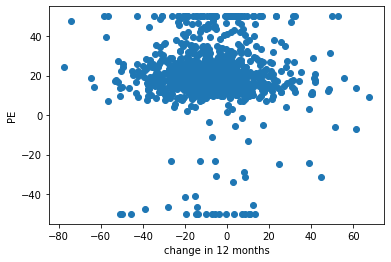

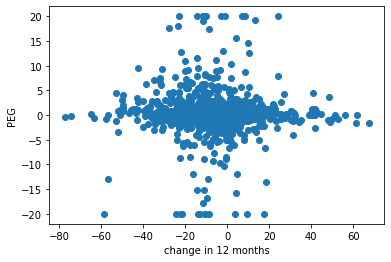

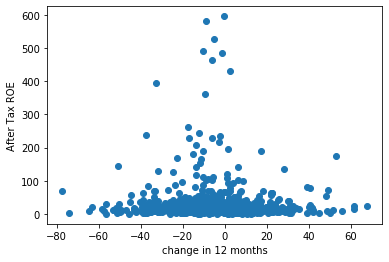

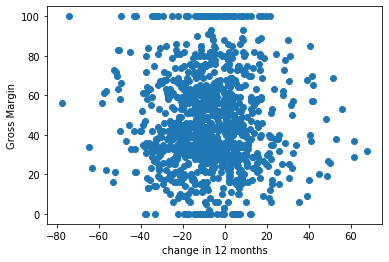

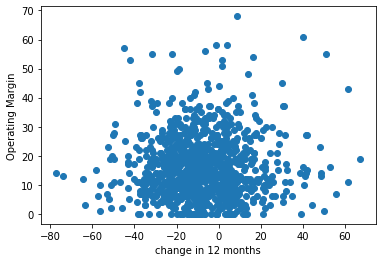

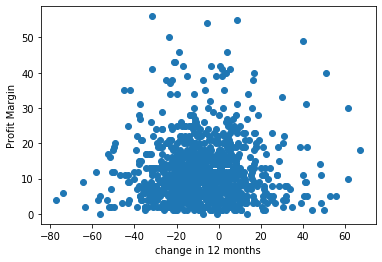

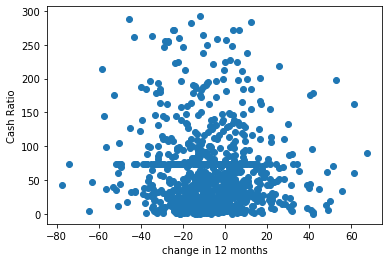

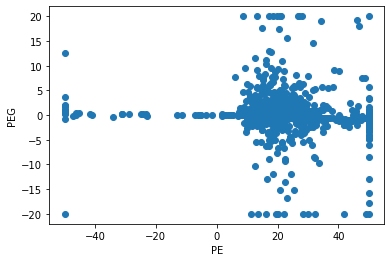

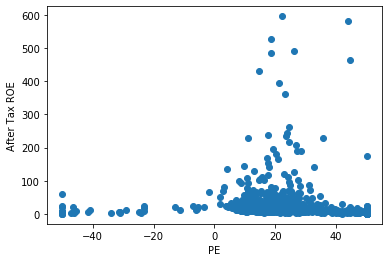

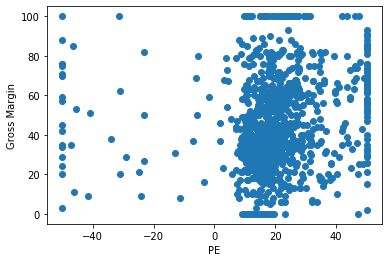

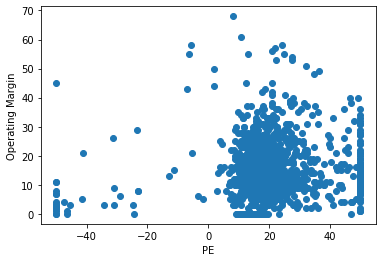

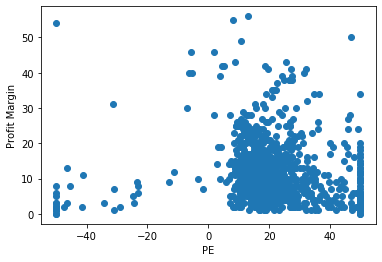

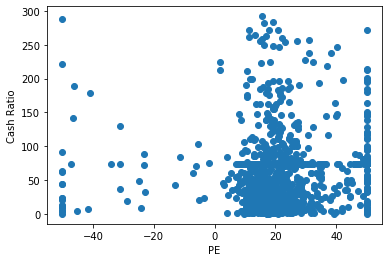

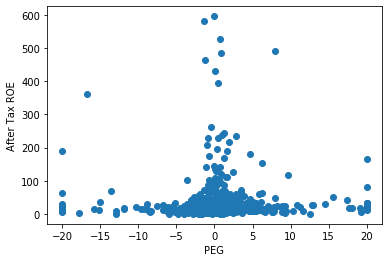

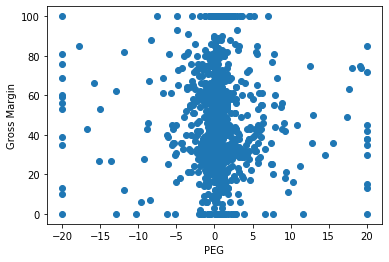

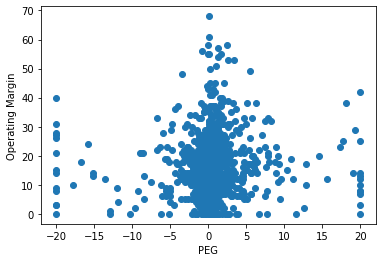

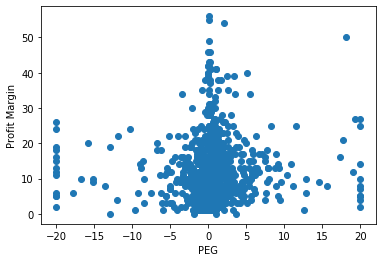

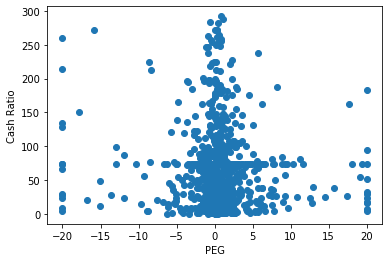

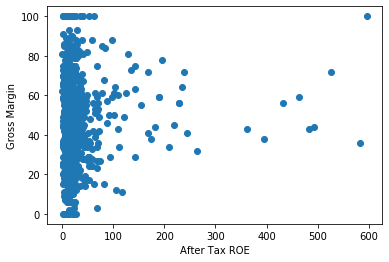

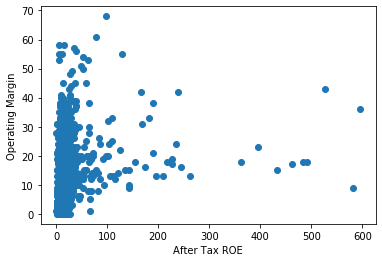

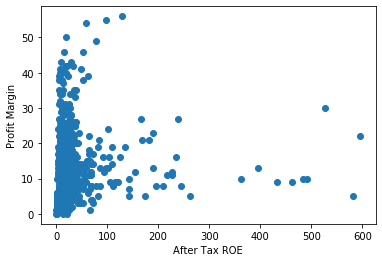

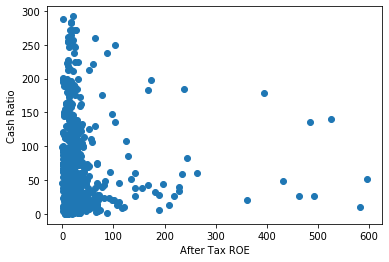

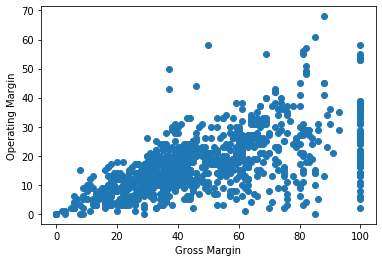

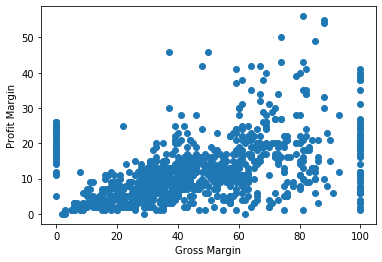

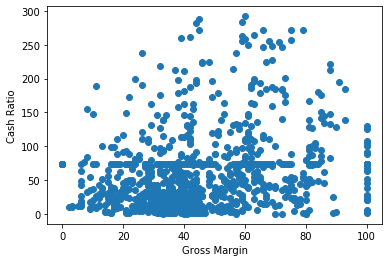

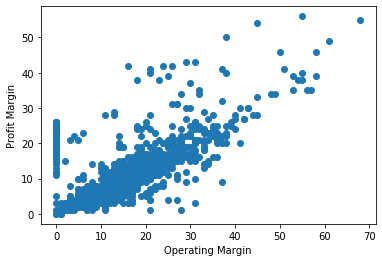

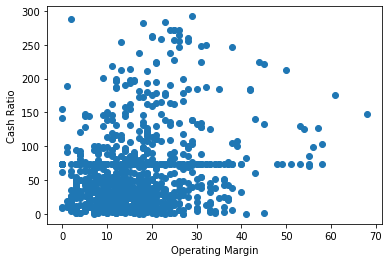

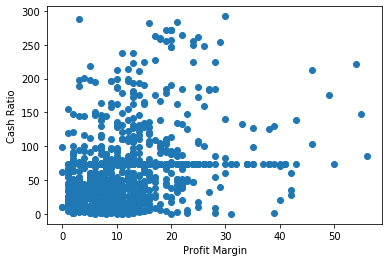

In [55]:
#rescaledSubSet.reset_index()
# = rescaledSubSet.drop(columns=['index','level_0'])

columnsToCompare = newDR.columns[2:]
print(columnsToCompare)

##Run through each feature and take compare it to all the features it has not been compare to before in the loop.
i = 3 # initila x index +1
for x in columnsToCompare:
    j = len(columnsToCompare)+1
    c = i
    while(j>=c):
        plt.figure()
        X = newDR[x].values
        y = newDR.iloc[:,c].values
        plt.xlabel(x)
        plt.ylabel(newDR.iloc[:,[c]].columns[0])
        plt.scatter(X,y)
        c = c+1
    i=i+1

    
    

***
## Encode labels for classification (12 month change)

Mean: -7.483743907549341
Standard deviation: 18.447022406633153


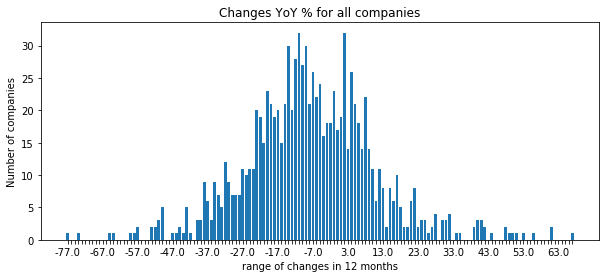

In [158]:

plotTargetValuesForAllSymbols(newDR, [0,0,1], 'change in 12 months', 'range of changes in 12 months', 'Changes YoY % for all companies', 10)
print("Mean:", newDR['change in 12 months'].mean())
print("Standard deviation:", newDR['change in 12 months'].std())


-77.30347577124176
67.45029920202941


,year,symbol,change in 12 months,PE,PEG,After Tax ROE,Gross Margin,Operating Margin,Profit Margin,Cash Ratio,changeLabel
0,2013,AAL,7.17011,-1.70933,-0.0169421,67,59,5,7,75,3
1,2014,AAL,-51.0061,9.82214,-0.0723635,143,63,10,7,60,0
2,2015,AAL,28.1448,4.25022,0.023183,135,73,15,19,51,3
3,2013,AAP,-1.96607,17.0979,12.9212,26,50,10,6,40,2
4,2016,AAP,-21.1023,24.8504,-5.59134,19,45,8,5,2,0
5,2014,AAPL,-14.2301,14.8076,-0.176729,35,39,29,22,40,1
6,2015,AAPL,25.589,11.7672,0.273725,45,40,30,23,52,3
7,2016,AAPL,-23.7324,13.1293,-1.31011,36,39,28,21,85,0
8,2014,ABC,-7.44926,50,-1.88747,14,2,1,0,10,2
9,2015,ABC,-0.625269,-50,1.04312,22,3,0,0,10,2


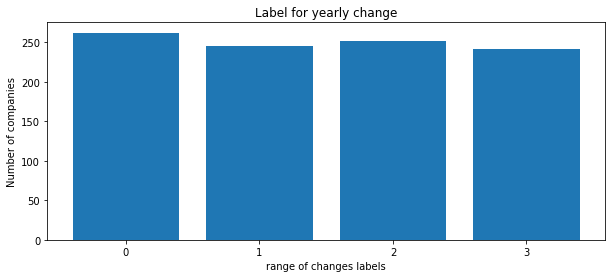

In [58]:
#rangeList is a double list with the format [[x1,x2],[x3,x4],[x5,x6],[x7,x8]]
def labelColumnByRanges(rangeList, dataFrame, targetColumn, outputColumnName):
    #Get a subset of target column entries
    targetColumnValues = dataFrame[targetColumn]
    labels = []
    for value in targetColumnValues:
        state = None #state will remain None if the value does not belong to any set of ranges.
        if (value>=rangeList[0][0]) & (value<rangeList[0][1]):
            state = 0
        elif (value>=rangeList[1][0]) & (value<rangeList[1][1]):
            state = 1
        elif (value>=rangeList[2][0]) & (value<rangeList[2][1]):
            state = 2
        elif (value>=rangeList[3][0]) & (value<rangeList[3][1]):
            state = 3
        labels.append(state)
    
    
    labelsNP = np.array(labels) #turn labels into a np array
    #labels are appended using the original data frame
    dataFrameWithLabels = np.append(dataFrame, labelsNP[:,np.newaxis], axis = 1)
    #a new dataset is created and the appended column is named.
    newDataFrame = pd.DataFrame(data=dataFrameWithLabels, columns = np.append(dataFrame.columns, [outputColumnName]))
    return newDataFrame

minDR = np.min(newDR['change in 12 months'])
maxDR = np.max(newDR['change in 12 months'])
print(minDR)
print(maxDR)

finalToSave = labelColumnByRanges([[minDR,-18],[-18,-8],[-8,4],[4,maxDR+1]],newDR, 'change in 12 months', 'changeLabel')



plotTargetValuesForAllSymbols(finalToSave, [0,0,1], 'changeLabel', 'range of changes labels', 'Label for yearly change', 1)
finalToSave.to_csv("./preprocessing/fundamentals_preprocessed_final.csv")
finalToSave.head(20)

***
# Unsupersvised learning to try to see any relationships between features.

## PCA
Dimensionality reduction in order to find the most significant variances.

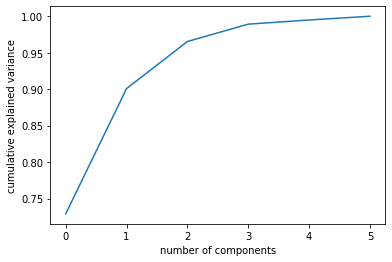

In [59]:
from sklearn.decomposition import PCA
pca = PCA().fit(finalToSave.iloc[:,3:9])


plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

### 2 Components describe around 95 % of the variance

***
## With target as change label

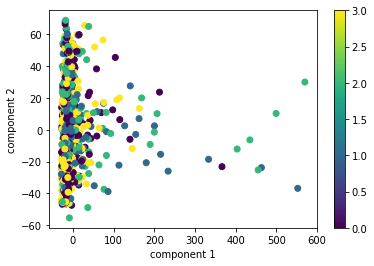

In [61]:
targetChangeLabel = finalToSave['changeLabel']
target = finalToSave.loc[:,'change in 12 months']


pca = PCA(n_components=2)
projected = pca.fit_transform(finalToSave.iloc[:,3:9])
plt.scatter(projected[:,0], projected[:,1], c=targetChangeLabel, alpha=1)

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()